In [97]:
import os
import cv2
import glob
import json
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
#from progressbar import * #进度条
from tqdm import tqdm #进度条
from torchnet import meter
from natsort import natsorted
import matplotlib.pyplot as plt
import torch.nn.functional as F #torch是关于运算的包
from collections import defaultdict
from torch.autograd import Variable
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from torch.utils.data import Dataset
from torchvision import transforms as T
from torchvision import datasets,transforms, models #torchvision则是打包了一些数据集
#from sklearn.cross_validation import train_test_split
os.environ['CUDA_VISIBLE_DEVICES']='3'

### 数据预处理
#### 主要对图片数量小于10的图片扩充包括数据扩充

In [25]:
train_csv = pd.read_csv("data/train.csv")
temp_df = train_csv.groupby('Id').count()
#temp_df_subset = temp_df[temp_df.Image == 1]
temp_df_subset = temp_df[temp_df.Image <=10]
#print(temp_df_subset.shape)
#print(temp_df_subset)
temp_df_subset.to_csv('data/less10.csv')
less10 = pd.read_csv('data/less10.csv')
#print(less10.iloc[:, 0].values)
less10_class = less10.iloc[:, 0].values
print(less10_class)

['w_0003639' 'w_0003c59' 'w_0027efa' ... 'w_ffa6d42' 'w_ffcf5fe'
 'w_ffe8693']


In [21]:
def augmentDataSet(data_path, floder_list, seq):
    for floder in tqdm(floder_list):
        img_path = glob.glob(data_path + '/'+floder + '/*')
        
        if len(img_path) > 8:
            n = 2
        elif len(img_path) > 5:
            n = 3
        elif len(img_path) > 3:
            n = 5
        elif len(img_path) > 1:
            n = 9
        else:
            n = 10
            
        imglist = []
        for path in img_path:
            img = cv2.imread(path)
            imglist.append(img)
        for i in range(n):
            img_aug = seq.augment_images(imglist)
            for idx, img_ in enumerate(img_aug):
                cv2.imwrite(data_path + '/'+floder+'/aug_'+str(i + idx)+'.jpg', img_)

In [26]:
seq = iaa.Sequential([
    iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
    iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
    #iaa.Flipud(0.5), #上下翻转
    #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
    iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-20, 20)),#旋转
    iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
],random_order=True)#每个batch中的Augmenters顺序不一样

data_path = 'data/train_aug_10'
augmentDataSet(data_path, less10_class, seq)

100%|██████████| 4777/4777 [35:47<00:00,  2.47it/s]


#### 生成文件标签list

In [69]:
def generateFileList(data_path):
    file_class_list = []
    #file_class_dict = {}
    file_list = []
    for label in os.listdir(data_path):
        floder = data_path + '/' + label
        files = glob.glob(floder + '/*')
        #file_label = []
        for img_path in files:
            #file_label.append([img_path, label])
            #file_class_dict[str(img_path)] = label
            file_list.append(img_path)
            file_class_list.append([img_path, label])
    return file_list, file_class_list

In [87]:
file_list, file_class_list = generateFileList('data/train_aug_10')
#print(file_class_dict['data/train_aug_10/w_1efbb8e/b24ca77e2.jpg'])
print(len(file_class_list))
print(file_class_list[:10])
#print(file_class_dict[0])
print(len(file_list))

72669
[['data/train_aug_10/w_05bf34e/aug_6.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/aug_4.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/aug_10.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/aug_5.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/aug_1.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/c6a6fe666.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/aug_2.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/ea8520852.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/aug_7.jpg', 'w_05bf34e'], ['data/train_aug_10/w_05bf34e/aug_9.jpg', 'w_05bf34e']]
72669


In [91]:
### 划分验证集 ###
#打乱顺序
num_example=len(file_class_list)
np.random.shuffle(file_class_list)

VALIDATION_SIZE = int(0.8*num_example)  #验证集大小
train_list, val_list = file_class_list[:VALIDATION_SIZE], file_class_list[VALIDATION_SIZE:]
print(len(train_list), len(val_list))

#转化为字典形式
file_id_mapping_train = {}
for item_ in train_list:
    k, v = item_[0], item_[1]
    file_id_mapping_train[k] = v
file_id_mapping_val = {}
for item_ in val_list:
    k, v = item_[0], item_[1]
    file_id_mapping_val[k] = v
#file_id_mapping_train = {k: v for k, v in zip(train_list[], train.Id.values)}
#file_id_mapping_test = {k: v for k, v in zip(test.Image.values, test.Id.values)}
print(len(file_id_mapping_val))
print(file_id_mapping_train['data/train_aug_10/w_593949b/aug_0.jpg'])

58135 14534
14534
w_593949b


In [133]:
class TrainAndValData(Dataset):
    def __init__(self, file_class_dict, train=True, img_size=224, other_class = "new_whale"):
        self.train = train
        self.file_class_mapping = file_class_dict
        self.class_to_list_files = defaultdict(list)
        self.list_other_class = []
        self.list_all_files = list(file_class_dict.keys())
        self.range_all_files = list(range(len(self.list_all_files)))
        for file, class_ in file_class_dict.items():
            if class_ == other_class:
                self.list_other_class.append(file)
            else:
                self.class_to_list_files[class_].append(file)   
                
        self.list_classes = list(set(self.file_class_mapping.values()))
        self.range_list_classes= range(len(self.list_classes))
        self.class_weight = np.array([len(self.class_to_list_files[class_]) for class_ in self.list_classes])
        self.class_weight = self.class_weight/np.sum(self.class_weight)
        
        normalize = T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
        if self.train == True:
            self.transforms = T.Compose([
                transforms.Grayscale(3),
                transforms.Resize((img_size, img_size)),
                T.RandomHorizontalFlip(),
                transforms.ToTensor(),
                #normalize
            ])
        else:
            self.transforms = T.Compose([
                transforms.Grayscale(3),
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                #normalize
            ]) 
    def __getitem__(self, index):
        #index 暂时无用
        class_idx = np.random.choice(self.range_list_classes, 1, p=self.class_weight)[0]
        examples_class_idx = np.random.choice(range(len(self.class_to_list_files[self.list_classes[class_idx]])), 2)
        positive_path_1, positive_path_2 = \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[0]],\
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[1]]
        
        #positive_example_1 = self.imgs[index].keys
        
        negative_path = None
        while negative_path is None or self.file_class_mapping[negative_path] == \
                self.file_class_mapping[positive_path_1]:
            negative_example_idx = np.random.choice(self.range_all_files, 1)[0]
            negative_path = self.list_all_files[negative_example_idx]
        
        positive_example_1 = Image.open(positive_path_1)
        positive_example_1 = self.transforms(positive_example_1)
        negative_example = Image.open(negative_path)
        negative_example = self.transforms(negative_example)
        positive_example_2 = Image.open(positive_path_2)
        positive_example_2 = self.transforms(positive_example_2)
        
        return positive_example_1, negative_example, positive_example_2        
    def __len__(self):
        return len(self.file_class_mapping)

In [134]:
train_dataset = TrainAndValData(file_id_mapping_train, train=True)

train len is 58135
(3, 224, 224)


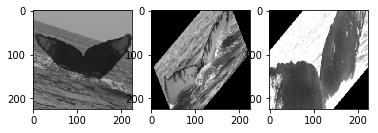

(3, 224, 224)


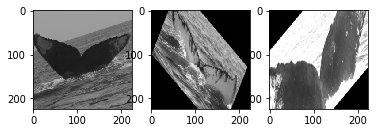

(3, 224, 224)


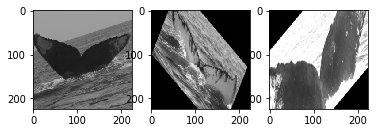

(3, 224, 224)


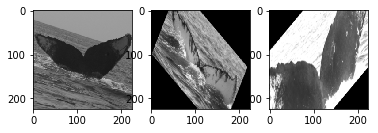

(3, 224, 224)


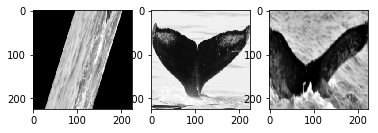

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd0b53e4b38>>
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
 

In [135]:
print('train len is %d' % len(train_dataset))
train_dataloader = torch.utils.data.DataLoader(train_dataset, 1, shuffle=True, num_workers=4)
for i, (data1, data2, data3) in enumerate(train_dataloader):
    if i < 5:
        img1 = data1[0].numpy()
        print(img1.shape)
        img2 = data2[0].numpy()
        img3 = data3[0].numpy()
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(img1,(1,2,0)))
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(img2,(1,2,0)))
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(img3,(1,2,0)))
        plt.show()
    else:
        break